In [100]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import csv
import re
from nltk import corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [101]:
# get data in notebook
df = pd.read_csv(r"C:\Users\tonym\Documents\Flatiron\phase_5\capstone\MBTI-ML-Social-Media-\data\mbti_1.csv")

In [102]:
print(df.iloc[0,1])

'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...|

- website links appear frequently 
- 4 letter meyers briggs codes are are refrenced frequently. Could bias the models

In [103]:
# check top and bottom of data set 
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [104]:
df.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [105]:
# 
df.shape

(8675, 2)

Over 8500 rows. Posts and type appear to be the only columns.

In [106]:
# check for null values in the set 
df.isnull().sum()

type     0
posts    0
dtype: int64

In [107]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,"'INTP female. Most: ENTJ, ESTJ, ENFJ Least: I..."
freq,1832,1


no null values 

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [109]:
# checking how many records there are for each personality type 
df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

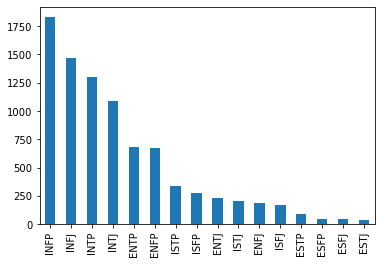

In [110]:
# showing type counts as visulaization 
df['type'].value_counts().plot(kind = 'bar')
plt.show()

Looks like INFP, INFJ, INTP are the most popular. Other types are much lower. Dataset is pretty unbalanced.


Deciding on how to deal with data imbalance. Different ways to do this could be: 
- Oversampling
- Downsampling
- SMOTE
- Near Miss
- gather more data 

 In order to handle the imbalance a good way we can convert the 16 classes into 4 classes. These new 4 classes will be more balanced. This will also make help the machine learning models classify the text as there are less classes to work with

In [111]:
# will put a 0 or 1 in the column if they contain a certian letter of the df 
df["Extrovert"] = df["type"].apply(
    lambda x: 1 if x[0] == "E" else 0
)
df["Sensing"] = df["type"].apply(
    lambda x: 1 if x[1] == "S" else 0
)
df["Thinking"] = df["type"].apply(
    lambda x: 1 if x[2] == "T" else 0
)
df["Judging"] = df["type"].apply(
    lambda x: 1 if x[3] == "J" else 0
)    

In [112]:
# rearragening columns and checking data
df = df[["type","Extrovert", "Sensing", "Thinking","Judging", "posts"]]
df.head()

,type,Extrovert,Sensing,Thinking,Judging,posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...


 we cano now count the values of each type of person on the 4 key dimensions. They can now be characterized as: 

- Extroversion vs. Introversion
I - 0
E - 1
- Sensing vs. Intuition
I - 0
S - 1
- Thinking vs. Feeling
F - 0
T - 1
- Judging vs. Perceiving
P - 0
J - 1


In [113]:
introvert_count = df["Extrovert"].value_counts()[0]
extrovert_count = df["Extrovert"].value_counts()[1]

intuition_count = df["Sensing"].value_counts()[0]
sensing_count = df["Sensing"].value_counts()[1]

feeling_count = df["Thinking"].value_counts()[0]
thinking_count = df["Thinking"].value_counts()[1]

perceiving_count = df["Judging"].value_counts()[0]
judging_count = df["Judging"].value_counts()[1]

In [114]:
# printing all the counts
print(f"Introvert Count: {introvert_count}")
print(f"Extrovert Count: {extrovert_count}")
print(f"Intuition Count: {intuition_count}")
print(f"Sensing Count: {sensing_count}")
print(f"Feeling Count: {feeling_count}")
print(f"Thinking Count: {thinking_count}")
print(f"Perceiving Count: {perceiving_count}")
print(f"Judging Count: {judging_count}")

Introvert Count: 6676
Extrovert Count: 1999
Intuition Count: 7478
Sensing Count: 1197
Feeling Count: 4694
Thinking Count: 3981
Perceiving Count: 5241
Judging Count: 3434


Intuitiveness ,introversion , Perceptiveness all appear very often in this data set

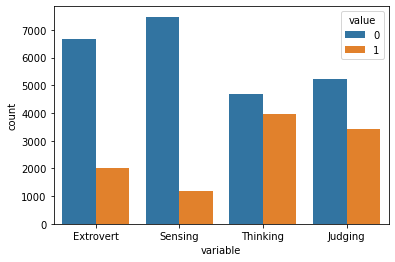

In [115]:
# we can visualize these counts 
sns.countplot(
    x="variable",
    hue="value",
    data=pd.melt(
        df[["Extrovert", "Sensing", "Thinking", "Judging"]]
    )
   
)
plt.show()

We can see from this graph 
- dataset is heavily skewed towards introvertion and intuitiveness
- slighty skewed towards feeling and judging 


### Cleaning Data

Instead of using a tokenzier I cam just going to code out some data cleaning manually. This is for making the social media posts lower case, remove spaces, also dropping mentions of df mentioned in the posts as this could skew our models. I will make a new column for the cleaned posts.

In [116]:
# lower case 
df['cleaned posts'] = df['posts'].str.lower()

In [117]:
# replacing '|||' seperators with white space 
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r"\|\|\|"), " ")
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"), "")

In [118]:
# dropping punctuations 
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r"[^a-z\s]"), " ")

In [119]:
# dropping emails which are not significant 
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r"\S+@\S+"), "")

In [120]:
df.head()

,type,Extrovert,Sensing,Thinking,Judging,posts,cleaned posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp and intj moments sportscenter not t...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,i m finding the lack of me in these posts ver...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,good one of course to which i say ...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the o...
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,you re fired that s another silly misconcept...


### Normalizing Text 

For this process I am going to use lemmatization. Lemmtization switches any kind of a word to its base root mode. It has a higher accuracy rate then stemming but it takes longer. It always gives the dictionary defintion when converting to root form 
so its better when the meaning of the word is important for analysis. This will take a while to run

In [74]:
lem = WordNetLemmatizer()

df['cleaned posts'] = df['cleaned posts'].apply(
    lambda x: " ".join(
        [
            lem.lemmatize(word)
            for word in x.split(" ")
            if word not in stopwords.words("english")
                                   
        ]
    )
    
)



In [121]:
# dropping df mentioned in the posts. 
#mbti = df["type"].unique()
#for type_word in df:
#    df["cleaned posts"] = df["cleaned posts"].str.replace(type_word.lower(), "")

In [123]:
# dropping stopwards
remove_words = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', \
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']

In [124]:
pat = r'\b(?:{})\b'.format('|'.join(remove_words))
df['cleaned posts'] = df['cleaned posts'].str.replace(pat, '')

Lets also remove up to 2 character words that don't have much significance.  

In [127]:
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r'\b\w{1,2}\b'), "")

In [128]:
df.head()

,type,Extrovert,Sensing,Thinking,Judging,posts,cleaned posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top ten p...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,finding the lack these very alarming s...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,good one course which say know...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed our conversation the other ...
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,you fired that another silly misconception...


In [129]:
# drop the uneeded posts column 
df_clean = df.copy()

In [79]:
# df_clean = df_clean.drop(columns = 'posts')

In [130]:
df_clean.head()

,type,Extrovert,Sensing,Thinking,Judging,posts,cleaned posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top ten p...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,finding the lack these very alarming s...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,good one course which say know...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed our conversation the other ...
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,you fired that another silly misconception...


In [134]:
df_clean['cleaned posts'][3]

' dear      enjoyed our conversation the other day   esoteric gabbing about the nature  the universe and the idea that every rule and social code being arbitrary constructs created    dear  sub    long time  see   sincerely  alpha none  them  all other  hurt  deep existential ways that  want  part   probably  sliding scale that depends  individual preferences  like everything  humanity  draco malfoy also    say   either             either           though  which stacking     somewhat arbitrary distinction  make   believe that the core indicates primary motivation and has  hand  every action  therefore        not particularly introverted  extraverted  personally  that said   would say   somewhat unphased  either social interactions  being alone  what   say  crave more  than anything     dear       your absolute admiration    refreshing  you   great girlfriend and  wish  both didn  have such busy schedules   could  around one another more often   keep       still means about      people 

In [133]:
#save cleaned dataframe 
df_clean.to_csv(r"C:\Users\tonym\Documents\Flatiron\phase_5\capstone\MBTI-ML-Social-Media-\data\df_clean.csv", index = False)